In [1]:
from tensorflow.keras import backend as K
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option("display.precision", 2)
from pathlib import Path
from tqdm import tqdm
import tensorflow as tf
import tensorflow.keras as keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
import random
import math

from helpers import ordinal_to_label, digitize, plot_confusion_matrix, plot_model_history, label_to_one_hot_like, one_hot_like_to_label, plot_cm_matrix


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [3]:
np.set_printoptions(precision=2)
plt.rcParams["figure.figsize"] = (10, 10)

### load data

In [4]:
df = pd.read_pickle("./all_session.pkl")
df.head()

combined_eye_closure  left_image_eye_closure  \
filename frame                                                 
001_1_a  0                      0.26                    0.25   
         1                      0.27                    0.22   
         2                      0.27                    0.23   
         3                      0.27                    0.22   
         4                      0.26                    0.22   

                right_image_eye_closure  combined_eye_state  \
filename frame                                                
001_1_a  0                         0.28                   0   
         1                         0.31                   0   
         2                         0.32                   0   
         3                         0.32                   0   
         4                         0.31                   0   

                left_image_eye_state  right_image_eye_state  subject_id  \
filename frame                                                            
001_1_a  0                         0                      0           1   
         1                         0                      0           1   
         2                         0                      0           1   
         3                         0                      0           1   
         4                         0                      0           1   

                session_id  session_type  num_blinks  mean_blink_length  \
filename frame                                                            
001_1_a  0               1             0           0                0.0   
         1               1             0           0                0.0   
         2               1             0           0                0.0   
         3               1             0           0                0.0   
         4               1             0           0                0.0   

                mean_opening_velocity  mean_closing_velocity  \
filename frame                                                 
001_1_a  0                        0.0                    0.0   
         1                        0.0                    0.0   
         2                        0.0                    0.0   
         3                        0.0                    0.0   
         4                        0.0                    0.0   

                karolinska_response_nearest_interpolation  \
filename frame                                              
001_1_a  0                                              6   
         1                                              6   
         2                                              6   
         3                                              6   
         4                                              6   

                karolinska_response_linear_interpolation  
filename frame                                            
001_1_a  0                                             6  
         1                                             6  
         2                                             6  
         3                                             6  
         4                                             6

In [5]:
# columns
print(df.columns)

Index(['combined_eye_closure', 'left_image_eye_closure',
       'right_image_eye_closure', 'combined_eye_state', 'left_image_eye_state',
       'right_image_eye_state', 'subject_id', 'session_id', 'session_type',
       'num_blinks', 'mean_blink_length', 'mean_opening_velocity',
       'mean_closing_velocity', 'karolinska_response_nearest_interpolation',
       'karolinska_response_linear_interpolation'],
      dtype='object')


### train and test split

In [6]:
# filter out alcohol sessions
unique_indices = list(
    filter(lambda x: not "a" in x,
           df.index.get_level_values('filename').unique()))
subjects = list(set([filename.split("_")[0] for filename in unique_indices]))
random.shuffle(subjects)

test_size = .2
split_index = math.ceil(test_size * len(subjects))
test_subjects = subjects[:split_index]
train_subjects = subjects[split_index:]
print(test_subjects, train_subjects)
val_subjects = train_subjects[:2]
train_subjects = train_subjects[2:]

['011', '001'] ['008', '004', '009', '005', '014', '002', '003']


In [7]:
train_subjects = ["001", "002", "003", "004", "009"]
val_subjects = ["005", "008"]
test_subjecst = ["011", "014"]

In [8]:
# create boolean index mask
test_subject_mask = df.index.to_frame().filename.str.contains(
    "|".join(test_subjects))
train_subject_mask = df.index.to_frame().filename.str.contains(
    "|".join(train_subjects))
val_subject_mask = df.index.to_frame().filename.str.contains(
    "|".join(val_subjects))

In [9]:
test_df = df[test_subject_mask]
test_df = test_df.copy()
test_df = test_df[test_df["session_type"] != 0]
test_df = test_df.dropna()
#test_df = test_df.sample(frac=1)
# print(len(test_df))

train_df = df[train_subject_mask]
train_df = train_df.copy()
train_df = train_df[train_df["session_type"] != 0]
train_df = train_df.dropna()
#treain_df = train_df.sample(frac=1)
#print(len(train_df))

val_df = df[val_subject_mask]
val_df = val_df.copy()
val_df = val_df[val_df["session_type"] != 0]
val_df = val_df.dropna()
#treain_df = train_df.sample(frac=1)
#print(len(train_df))

feature_columns = [
       'num_blinks', 'mean_blink_length', 'mean_opening_velocity',
       'mean_closing_velocity']
target_columns = ["karolinska_response_linear_interpolation"]

X_train = train_df[feature_columns].astype(float).to_numpy()
X_test = test_df[feature_columns].astype(float).to_numpy()
X_val = val_df[feature_columns].astype(float).to_numpy()

y_train = train_df[target_columns].astype(float).to_numpy()
y_test = test_df[target_columns].astype(float).to_numpy()
y_val = val_df[target_columns].astype(float).to_numpy()

print(f"X_train.shape = {X_train.shape}")
print(f"X_test.shape = {X_test.shape}")
print(f"y_train.shape = {y_train.shape}")
print(f"y_test.shape = {y_test.shape}")

X_train.shape = (1336295, 4)
X_test.shape = (544460, 4)
y_train.shape = (1336295, 1)
y_test.shape = (544460, 1)


In [10]:
# set labels to [0, 8]
y_train = y_train - 1
y_test = y_test - 1
y_val = y_val -1 

In [11]:
# normalize
norm_layer = tf.keras.layers.experimental.preprocessing.Normalization()
norm_layer.adapt(X_train)
X_train = norm_layer(X_train)
X_test = norm_layer(X_test)
X_val = norm_layer(X_val)

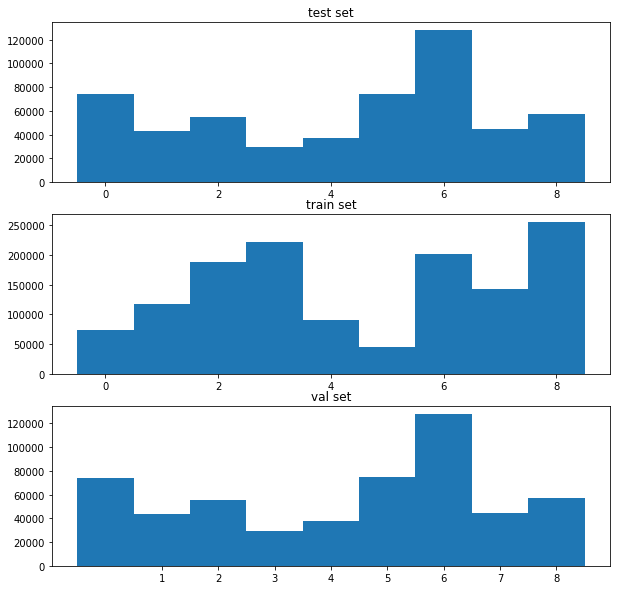

In [12]:
f, (ax1, ax2, ax3) = plt.subplots(3, 1)
bins = [x - .5 for x in range(0,10)]
ax1.hist(y_test, bins=bins)
ax1.set_title("test set")
ax2.hist(y_train, bins=bins)
ax2.set_title("train set")
ax3.hist(y_test, bins=bins)
ax3.set_title("val set")

plt.xticks(range(1, 9))
plt.show()

In [19]:
BATCH_SIZE = 2000
EPOCHS = 2

In [20]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)


In [21]:
def casted_accuracy(y_true, y_pred):
    y_true = tf.cast(y_true, tf.int32)
    y_pred = tf.cast(tf.add(y_pred,0.5), tf.int32)
    return tf.divide(
        tf.reduce_sum(tf.cast(tf.equal(y_pred, y_true), tf.int32)),
        tf.size(y_true))



loss = "mae"
optimizer = "sgd"
#optimizer = tf.keras.optimizers.Adam()

regression_model = Sequential()
regression_model.add(Dense(1, input_dim=X_train.shape[-1]))
regression_model.compile(loss=loss,
                         optimizer=optimizer,
                         metrics=[casted_accuracy, "mae"])
regression_model.summary()
with tf.device("cpu:0"):
    regression_history = regression_model.fit(X_train,
                                              y_train,
                                              epochs=EPOCHS,
                                              batch_size=BATCH_SIZE,
                                              validation_data=(X_val, y_val),
                                              callbacks=[callback])
    results = regression_model.evaluate(X_test, y_test, batch_size=BATCH_SIZE)
    print("test loss, test acc:", results)
regression_model.save(f"./models/regression_model_{loss}_{optimizer}_{BATCH_SIZE}_{EPOCHS}_{int(results[-1] * 100)}")

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 1)                 5         
Total params: 5
Trainable params: 5
Non-trainable params: 0
_________________________________________________________________
Epoch 1/2
669/669 [==============================] - 1s 1ms/step - loss: 3.6083 - casted_accuracy: 0.1177 - mae: 3.6083 - val_loss: 2.7964 - val_casted_accuracy: 0.0289 - val_mae: 2.7964
Epoch 2/2
273/273 [==============================] - 0s 502us/step - loss: 2.4683 - casted_accuracy: 0.0717 - mae: 2.4683
test loss, test acc: [2.4682750701904297, 0.07166299968957901, 2.4682750701904297]
INFO:tensorflow:Assets written to: ./models/regression_model_mae_sgd_2000_2_246/assets


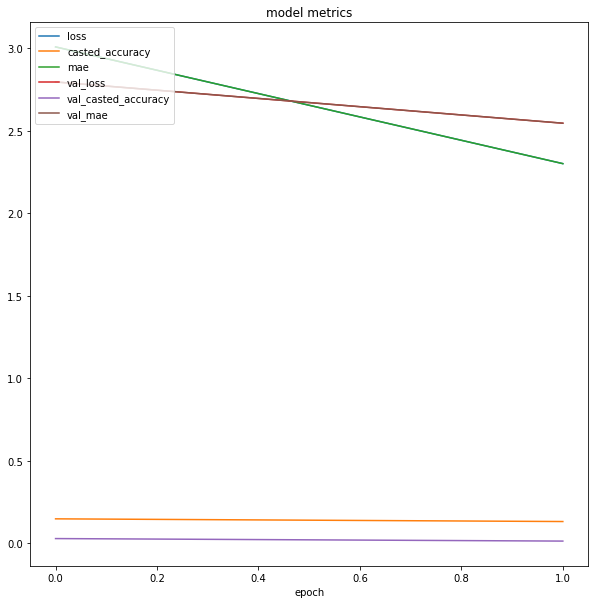

In [22]:
plot_model_history(regression_history)

In [23]:
for name, weigth in zip(feature_columns, regression_model.weights[0].numpy()):
    print(name, weigth)

print("bias", regression_model.weights[1].numpy())

num_blinks [0.76]
mean_blink_length [0.59]
mean_opening_velocity [-0.27]
mean_closing_velocity [-0.03]
bias [3.92]


In [24]:
print(f"Test MAE: {results[0]}")
print(f"Test Accuracy {results[1]}")

Test MAE: 2.4682750701904297
Test Accuracy 0.07166299968957901


Confusion matrix, without normalization


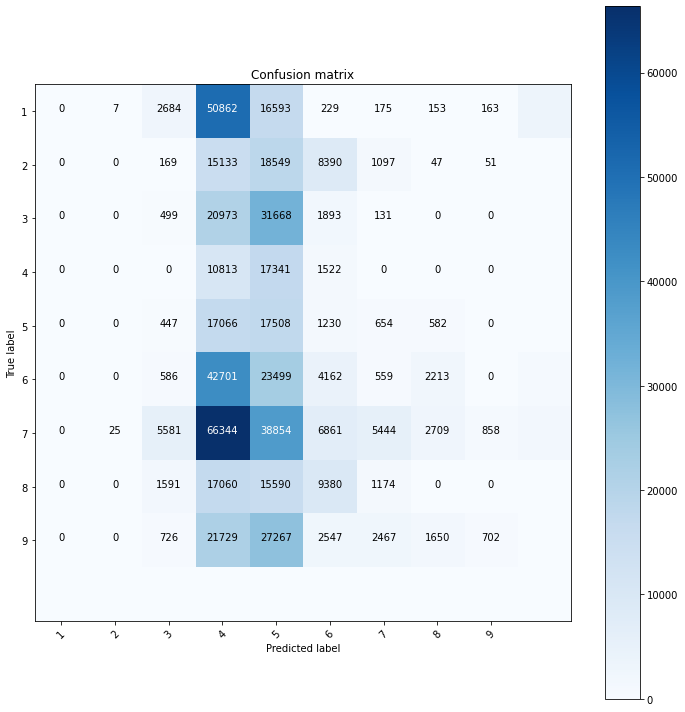

In [25]:
plot_cm_matrix(regression_model, X_test, y_test, output_kind="digitize")

### ordinal regression with sigmoid and one-hot-like encoding

In [ ]:
y_test_one_hot = label_to_one_hot_like(y_test.astype(int))
y_train_one_hot = label_to_one_hot_like(y_train.astype(int))
y_val_one_hot = label_to_one_hot_like(y_val.astype(int))

In [ ]:
def one_hot_like_accuracy(y_true, y_pred, threshold=.5):
    threshold = keras.backend.constant(threshold)
    y_pred = keras.backend.sum(keras.backend.cast(keras.backend.greater(
        y_pred, threshold),
                                                  dtype=tf.int64),
                               axis=1)
    y_true = keras.backend.sum(keras.backend.cast(keras.backend.greater(
        y_true, threshold),
                                                  dtype=tf.int64),
                               axis=1)
    return tf.divide(
        tf.reduce_sum(tf.cast(tf.equal(y_pred, y_true), tf.int32)),
        tf.size(y_true))

loss = 'categorical_crossentropy'
optimizer = 'adam'
one_hot_model = Sequential()
one_hot_model.add(Dense(8, input_dim=X_train.shape[-1], activation='sigmoid'))
one_hot_model.compile(loss=loss,
                      optimizer=optimizer,
                      metrics=[one_hot_like_accuracy])
one_hot_model.summary()
with tf.device("cpu:0"):
    one_hot_history = one_hot_model.fit(X_train,
                                        y_train_one_hot,
                                        epochs=EPOCHS,
                                        batch_size=BATCH_SIZE,
                                        validation_data=(X_val, y_val_one_hot),
                                        callbacks=[callback])
    results = one_hot_model.evaluate(X_test,
                                     y_test_one_hot,
                                     batch_size=BATCH_SIZE)
    print("test loss, test acc: ", results)
    
one_hot_model.save(f"./models/one_hot_model_{loss}_{optimizer}_{BATCH_SIZE}_{EPOCHS}_{int(results[-1] * 100)}")

In [ ]:
plot_model_history(one_hot_history)

In [ ]:
y_pred_raw = one_hot_model.predict(X_test)
print(y_pred_raw.shape)

In [ ]:
thresholds = np.linspace(.1, .9, 20)
accs = []
for threshold in thresholds:
    acc = one_hot_like_accuracy(y_test_one_hot,
                                y_pred_raw,
                                threshold=threshold)
#     print(threshold, acc)
    accs.append(acc)

best_threshold = thresholds[np.argmax(accs)]
print(f"max acc with threshold of {best_threshold}")
plt.plot(thresholds, accs)
plt.title("accuracy vs thresholds for assigning class")
plt.show()

In [ ]:
plot_cm_matrix(one_hot_model,
               X_test,
               y_test,
               output_kind="one-hot-like",
               threshold=best_threshold,
               normalize=False)

In [ ]:
preds = one_hot_like_to_label(y_pred_raw, threshold=best_threshold).numpy()
plt.hist(preds, bins=bins)
plt.show()

### coral model

In [ ]:
import coral_ordinal as coral

NUM_CLASSES = 9

loss = coral.OrdinalCrossEntropy(num_classes = NUM_CLASSES)
optimizer = tf.keras.optimizers.Adam()

ordinal_model = Sequential()
ordinal_model.add(Input(shape=X_train.shape[-1]))
#ordinal_model.add(Dense(10))
ordinal_model.add(coral.CoralOrdinal(num_classes = NUM_CLASSES))

ordinal_model.compile(optimizer=optimizer,
                      loss = loss,
                      metrics = [coral.MeanAbsoluteErrorLabels()])
ordinal_model.summary()

with tf.device("cpu:0"):
    ordinal_history = ordinal_model.fit(X_train,
                                        y_train,
                                        epochs=2,
                                        batch_size=BATCH_SIZE,
                                        validation_data=(X_val, y_val),
                                        callbacks=[callback])
    results = ordinal_model.evaluate(X_test,
                                     y_test,
                                     batch_size=BATCH_SIZE)
    print("test loss, test acc: ", results)
    
ordinal_model.save(f"./models/ordinal_model_{loss}_{optimizer}_{BATCH_SIZE}_{EPOCHS}_{int(results[-1] * 100)}")

In [ ]:
plot_model_history(ordinal_history)

In [ ]:
plot_cm_matrix(ordinal_model, X_test, y_test, output_kind="cum_logits")

In [ ]:
def ordinal_accuracy(y_true, y_pred):
    y_true = tf.squeeze(y_true)
    labels = ordinal_to_label(y_pred)
    print(labels.shape, y_true.shape)
    acc = np.mean(labels == y_true)
    return acc

num_samples = 10000
res = ordinal_model.predict(x=X_test[:num_samples])
ordinal_accuracy(y_test[:num_samples], res)

In [ ]:
l = ordinal_to_label(res)

In [ ]:
sum(np.squeeze(y_test)[:10000]  == l)

In [ ]:
# The output layer is the last layer in the model.
last_layer = len(ordinal_model.layers) - 1

# Check bias terms: these should be in descending order.
ordinal_model.layers[last_layer].get_weights()[1]

In [ ]:
plt.plot(ordinal_model.layers[last_layer].get_weights()[1])
plt.show()

# Different notes

### session types mapping:  
a -> 0  
b -> 1  
s -> 18

In [ ]:
list("123")